[Chat](https://chat.cborg.lbl.gov/c/b21a4f92-e4b2-401d-9f41-7293644a27ff)

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np

## Positional Encoding

Positional encoding itself does not go directly into the "attention" mechanism by itself — it is added to the token embeddings before the attention layers, so the attention mechanism can make use of positional information.

### How Transformers Process Input
In a transformer encoder, the first few steps look like this:


### Tokens → Embeddings
Each word (or subword) in your sequence is mapped to a dense vector:
$$\text{token\_embedding} \in \mathbb{R}^{d_{\text{model}}}$$
This captures semantic meaning but has no position info.


### Add Positional Encoding
We add the positional encoding vector to each token embedding:
$$\text{input\_to\_transformer} = \text{token\_embedding} + \text{positional\_encoding}$$
Now each vector contains both word meaning and position.


### Feed Into Self-Attention
The resulting vectors (with position info baked in) are used to compute Queries (Q), Keys (K), and Values (V) for the attention mechanism:
$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$
where $X$ is the sum of token embeddings and positional encodings.


### Attention Calculation
The self-attention mechanism computes:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
Without positional encodings, the attention mechanism would treat the sequence as a bag of words — it would have no way to know if a token is first, last, or in between.

## Why Not Feed Position Separately?
* You could feed positional information as a separate input, but the original Transformer design simply adds it to the embeddings. This way:
* The attention layers don’t need to be modified.
Position information is available from the very first layer.
### Analogy
Think of a transformer as a group of people in a meeting (attention heads).

* Token embeddings = what each person is saying.
* Positional encoding = a label telling you where each person is sitting around the table.
* Attention mechanism = deciding who listens to whom.

If you remove the seating labels, people can still hear each other, but they can’t tell who is speaking in what order.

In [4]:

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        # dim_model → size of each token embedding vector (e.g., 512 in the original Transformer paper).
        # dropout_p → probability for dropout to prevent overfitting.
        # max_len → maximum sequence length the model will handle.
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # After adding positional encodings, we apply dropout for regularization.
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        # We create a matrix of shape (max_len, dim_model) that will store the positional encodings for each position in the sequence.
        pos_encoding = torch.zeros(max_len, dim_model)

        # Position encoding formula
        # Creates a column vector, each row corresponds to the position index in the sequence.
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5

        # Division term for the positional encoding formula
        # This implements the formula from the Transformer paper (sin, cos)
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        # Reshape for Batch Compatibility
        # unsqueeze(0) → adds a batch dimension at the front.
        # transpose(0, 1) → final shape becomes (max_len, 1, dim_model),
        # which matches the (sequence_length, batch_size, embedding_dim) format used by PyTorch’s Transformer.
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)

        # Buffers are like parameters, but not updated during training.
        # This ensures positional encoding is stored with the model and moved to GPU with .to(device), but gradients are not computed for it.
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

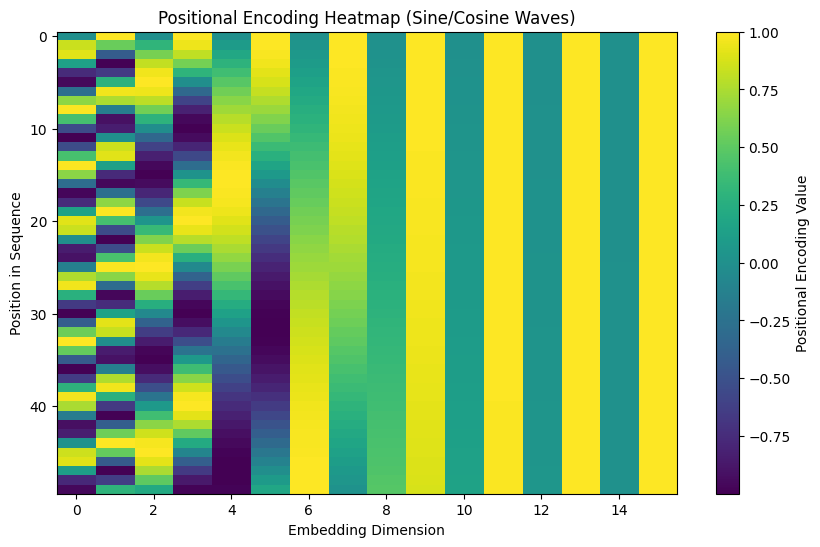

In [ ]:
import matplotlib.pyplot as plt
# --- Create positional encoding ---
dim_model = 16   # embedding size
max_len = 50     # sequence length
pos_enc = PositionalEncoding(dim_model, dropout_p=0.0, max_len=max_len)

# Remove batch dimension for plotting
pe_matrix = pos_enc.pos_encoding.squeeze(1)  # shape: (max_len, dim_model)

# --- Plot heatmap ---
plt.figure(figsize=(10, 6))
plt.imshow(pe_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label="Positional Encoding Value")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.title("Positional Encoding Heatmap (Sine/Cosine Waves)")
plt.show()

In [5]:
# --- Small test ---
torch.set_printoptions(precision=4, sci_mode=False)

# Small dimensions for clarity
dim_model = 4      # embedding size
max_len = 6        # max sequence length
dropout_p = 0.0    # turn off dropout for inspection

pos_enc = PositionalEncoding(dim_model, dropout_p, max_len)

print("=== Positional Encoding Matrix (max_len=6, dim_model=4) ===")
print(pos_enc.pos_encoding.squeeze(1))  # shape: (max_len, dim_model)

# Dummy token embeddings (seq_len=3, batch_size=1, dim_model=4)
dummy_embeddings = torch.zeros(3, 1, dim_model)
output = pos_enc(dummy_embeddings)

print("\n=== Output after adding positional encoding (seq_len=3) ===")
print(output.squeeze(1))

=== Positional Encoding Matrix (max_len=6, dim_model=4) ===
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988]])

=== Output after adding positional encoding (seq_len=3) ===
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998]])


## Transformer
This is a PyTorch module that:

* Embeds tokens (words, subwords, etc.)
* Adds positional encodings
* Passes them through a Transformer encoder-decoder stack
* Projects the output back to vocabulary space

### Transformer paremeters
* num_tokens → vocabulary size (number of unique tokens)
* dim_model → embedding size (must match d_model in transformer)
* num_heads → number of attention heads
* num_encoder_layers → how many encoder layers
* num_decoder_layers → how many decoder layers
* dropout_p → dropout probability

### Forward pass parameters
* src → source sequence token IDs (batch_size, src_len)
* tgt → target sequence token IDs (batch_size, tgt_len)
* tgt_mask → prevents the decoder from looking ahead at future tokens (causal mask)
* src_pad_mask / tgt_pad_mask → masks padding tokens so they don’t affect attention

In [10]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        # Positional encoding (above)
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        # Token Embedding
        # Converts token IDs into dense vectors of size dim_model.
        self.embedding = nn.Embedding(num_tokens, dim_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

        # Final projection from hidden dimension → vocabulary size.
        # Converts the Transformer output back into logits for each token. Output layer.
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        # Scales them by sqrt(dim_model) to keep variance stable (from the paper)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)

        # Adds positional encoding
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        # Swap axes to what nn.Transformer expects
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        # Encoder processes src (self-attention + feed-forward).
        # Decoder processes tgt (masked self-attention + cross-attention with encoder output).
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a square matrix where the each row allows one word more to be seen
        # Creates a causal mask for the decoder:
        # Lower triangular matrix = each position can only attend to itself and previous positions.
        # 0.0 means allowed, -inf means blocked (softmax will ignore these).

        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

# Data generator

In [11]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


# Training

A note about dropout

Dropout is a regularization technique that helps prevent overfitting.

During training only (not inference), dropout randomly sets some fraction (dropout_p) of the elements in a tensor to zero.
The remaining elements are scaled up so that the overall expected sum stays the same.
This forces the network to not rely too heavily on any single neuron/feature, encouraging more robust feature learning.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

/Users/jdtibochab/miniforge3/envs/transformers/lib/python3.9/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

# Validation

In [14]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

# Fitting

In [15]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5839
Validation loss: 0.4187

------------------------- Epoch 2 -------------------------
Training loss: 0.4230
Validation loss: 0.3942

------------------------- Epoch 3 -------------------------
Training loss: 0.4019
Validation loss: 0.3771

------------------------- Epoch 4 -------------------------
Training loss: 0.3854
Validation loss: 0.3568

------------------------- Epoch 5 -------------------------
Training loss: 0.3670
Validation loss: 0.3328

------------------------- Epoch 6 -------------------------
Training loss: 0.3492
Validation loss: 0.3034

------------------------- Epoch 7 -------------------------
Training loss: 0.3296
Validation loss: 0.2743

------------------------- Epoch 8 -------------------------
Training loss: 0.3132
Validation loss: 0.2568

------------------------- Epoch 9 -------------------------
Training loss: 0.3011
Validation loss: 0.2365

-------

# Predicting

In [20]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

